# Analysis - Engagements 
## 1. Load data

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality

import core.config as conf

In [2]:
client

Client Scheduler: tcp://127.0.0.1:41561 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

number of rows: 3033347


In [34]:
ori_df.head()

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,...,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp,id
id,,,,,,,,,,,,,,,,,,,,,
1,101\t12845\t10341\t55818\t13410\t10129\t23633\...,<NA>,C8F345CF8BC7A86E34572072ECFBBEC4,Photo\tPhoto,<NA>,<NA>,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1612993854,BC99C936FE4C2A1FDB0CD09295CAA53C,...,76,189,False,1435892882,True,0,0,0,1613048460,1
2,101\t56898\t137\t181\t10123\t10410\t168\t168\t...,E48B050ADC7D0DE54FA50374F4C9A063\tCF4C782EBE1C...,C1E31636C343B780BA776E4B73147028,<NA>,<NA>,<NA>,Retweet,9FCF19233EAD65EA6E32C2E6DC03A444,1612886900,F4ADB8DEADF1980D0B5C2B796C108F78,...,260,379,False,1393057295,False,0,0,0,0,2
3,101\t11916\t16818\t117\t10911\t35691\t10638\t1...,<NA>,B436C84E80C2430BA9DE41FDF04C73BF,<NA>,<NA>,<NA>,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1614019237,59EBFE44ABE4C5E31528340304F529C3,...,1259,868,False,1587102370,True,1614019431,0,0,0,3
4,101\t66676\t53622\t11499\t38356\t10703\t12843\...,<NA>,033FFA42C8AD502057AE96C8B4B812BE,<NA>,<NA>,<NA>,TopLevel,1F73BB863A39DB62B4A55B7E558DB1E8,1612779567,DF6A02AB1731A91FA46A2259F398F57B,...,437,597,False,1419347918,True,0,0,0,1612780118,4
5,101\t56898\t137\t158\t168\t10111\t168\t100061\...,<NA>,84F2E902BA3CF3B34B8D056F6F78D488,<NA>,<NA>,<NA>,Retweet,E7F038DE3EAD397AEC9193686C911677,1613822114,A656845C3239DB662CFD45D64F2B94F5,...,247,404,False,1507470713,True,0,0,0,0,5


In [6]:
columns = [
    "reply_timestamp",
    "retweet_timestamp",
    "retweet_with_comment_timestamp",
    "like_timestamp"
]
df = ori_df[columns]

In [7]:
df.head()

,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
id,,,,
1,0,0,0,1613048460
2,0,0,0,0
3,1614019431,0,0,0
4,0,0,0,1612780118
5,0,0,0,0


## 2. Number of a certain type of engagement with respect to the total amount of engagements


In [8]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df['is_reply'] | df['is_retweet'] | df['is_comment'] | df['is_like']
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)


In [9]:
n_engagements = len(df)
print('The total amount of engagements : ', n_engagements)

The total amount of engagements :  3033347


Positive engagements :  1513814
Negative engagements :  1519533
Reply engagements :  90061
Rtweet engagements :  265563
Comment engagements :  21347
Like engagements :  1207792


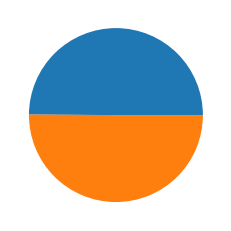

In [10]:
n_positive_engagements = df['is_positive'].compute().sum()
n_negative_engagements = df['is_negative'].compute().sum()
n_reply_engagements = df['is_reply'].compute().sum()
n_retweet_engagements = df['is_retweet'].compute().sum()
n_comment_engagements = df['is_comment'].compute().sum()
n_like_engagements = df['is_like'].compute().sum()

print('Positive engagements : ', n_positive_engagements)
print('Negative engagements : ', n_negative_engagements)
print('Reply engagements : ', n_reply_engagements)
print('Rtweet engagements : ', n_retweet_engagements)
print('Comment engagements : ', n_comment_engagements)
print('Like engagements : ', n_like_engagements)

plt.pie([n_positive_engagements, n_negative_engagements])
plt.show()

## 3. Number of rows that involves more than one engagement


In [11]:
df['number_of_engagements'] = df[['is_like', 'is_retweet', 'is_reply', 'is_comment']].sum(axis=1).astype(np.uint8)

Min number of different engagement types in a row: 0
Max number of different engagement types in a row: 4
Mean number of different engagement types in a row: 0.5224469867773123


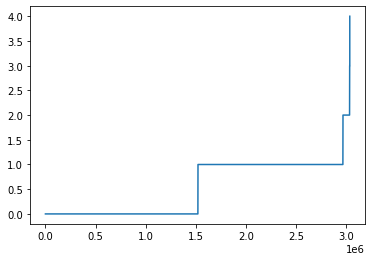

In [12]:
computed_number_of_engagements = df['number_of_engagements'].compute()

print(f"Min number of different engagement types in a row: {computed_number_of_engagements.min()}")
print(f"Max number of different engagement types in a row: {computed_number_of_engagements.max()}")
print(f"Mean number of different engagement types in a row: {computed_number_of_engagements.mean()}")

# Plotting the result
plt.clf()
plt.plot(sorted(computed_number_of_engagements.to_array()))
plt.show()


Rows with 0 engagements are 1519533 (50.0943%)
Rows with 1 engagements are 1445066 (47.6393%)
Rows with 2 engagements are 66574 (2.1947%)
Rows with 3 engagements are 2147 (0.0708%)
Rows with 4 engagements are 27 (0.0009%)


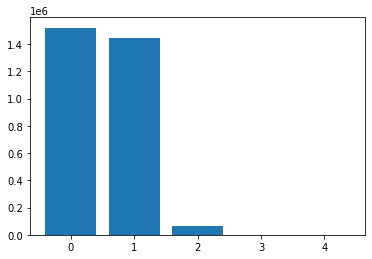

In [13]:
engagements_value_count = computed_number_of_engagements.value_counts()

idx = []
values = []
for i in range(5):
    idx.append(i)
    values.append(engagements_value_count[i])
    print(f"Rows with {i} engagements are {engagements_value_count[i]:n} ({engagements_value_count[i]/n_engagements*100:.4f}%)")

# Plotting the result
plt.bar(idx, values)
plt.show()

## 4. Let's do the same thing for each language


In [14]:
%%time
for col in ['language']:
    ori_df = factorize_small_cardinality(ori_df, col)


CPU times: user 226 ms, sys: 8.74 ms, total: 235 ms
Wall time: 3.1 s


In [15]:
df['language'] = ori_df['language_encode']

In [28]:
df.head()

,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,number_of_engagements,language
id,,,,,,,,
1,0,0,0,1,1,0,1,48
2,0,0,0,0,0,1,0,43
3,1,0,0,0,1,0,1,46
4,0,0,0,1,1,0,1,5
5,0,0,0,0,0,1,0,61


In [38]:
language_types = sorted(df['language'].compute().value_counts().index.to_array())
n_languages = len(language_types)

In [79]:
# Declaring some auxiliary structures
n_engagements_arr = np.zeros(n_languages).astype('int32')
n_positive_engagements_arr = np.empty(n_languages).astype('int32')
n_negative_engagements_arr = np.empty(n_languages).astype('int32')
n_like_engagements_arr = np.empty(n_languages).astype('int32')
n_retweet_engagements_arr = np.empty(n_languages).astype('int32')
n_reply_engagements_arr = np.empty(n_languages) .astype('int32')
n_comment_engagements_arr = np.empty(n_languages).astype('int32')

In [49]:
computed_df = df.compute()

In [82]:
for i in language_types:
    sub_df = computed_df[computed_df['language'] == i]
    n_engagements_arr[i] = len(sub_df)
    n_positive_engagements_arr[i] = sub_df['is_positive'].sum()
    n_negative_engagements_arr[i] = sub_df['is_negative'].sum()
    n_like_engagements_arr[i] = sub_df['is_like'].sum()
    n_retweet_engagements_arr[i] = sub_df['is_retweet'].sum()
    n_reply_engagements_arr[i] = sub_df['is_reply'].sum()
    n_comment_engagements_arr[i] = sub_df['is_comment'].sum()

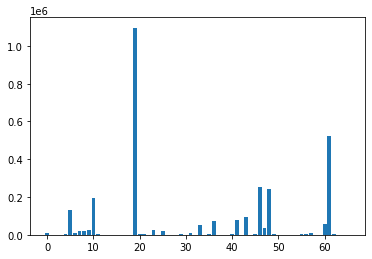

In [86]:
plt.bar(language_types, n_engagements_arr)
plt.show()


<BarContainer object of 66 artists>

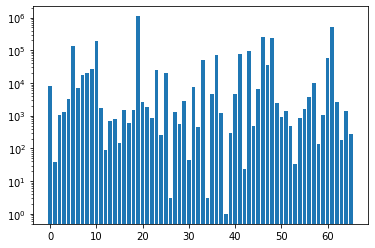

In [88]:
# In logaritmic scale
plt.yscale('log')
plt.bar(language_types, n_engagements_arr)

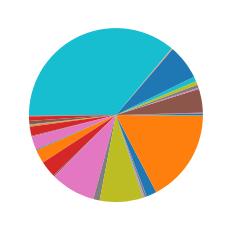

In [89]:
plt.pie(n_engagements_arr)
plt.show()

In [90]:
for i, count in enumerate(n_engagements_arr):
    print(f"Language {i} has {int(count):n} rows")

Language 0 has 8238 rows
Language 1 has 39 rows
Language 2 has 1018 rows
Language 3 has 1287 rows
Language 4 has 3349 rows
Language 5 has 133424 rows
Language 6 has 7103 rows
Language 7 has 17932 rows
Language 8 has 20750 rows
Language 9 has 27247 rows
Language 10 has 195341 rows
Language 11 has 1691 rows
Language 12 has 92 rows
Language 13 has 692 rows
Language 14 has 809 rows
Language 15 has 146 rows
Language 16 has 1505 rows
Language 17 has 598 rows
Language 18 has 1479 rows
Language 19 has 1096171 rows
Language 20 has 2717 rows
Language 21 has 1847 rows
Language 22 has 855 rows
Language 23 has 24784 rows
Language 24 has 249 rows
Language 25 has 19861 rows
Language 26 has 3 rows
Language 27 has 1291 rows
Language 28 has 574 rows
Language 29 has 2860 rows
Language 30 has 45 rows
Language 31 has 7518 rows
Language 32 has 457 rows
Language 33 has 51417 rows
Language 34 has 3 rows
Language 35 has 4635 rows
Language 36 has 74224 rows
Language 37 has 1238 rows
Language 38 has 1 rows
Langu

## 5. Percentage of engagement type for each language (red line is the percentage computed using all languages)


POSITIVE


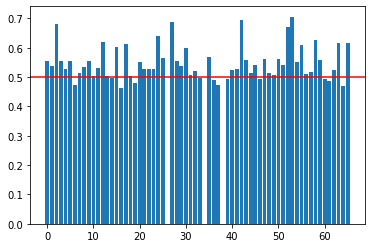

In [91]:
# Positive
print("POSITIVE")
percentage = n_positive_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_positive_engagements/n_engagements, color="red")
plt.show()

NEGATIVE


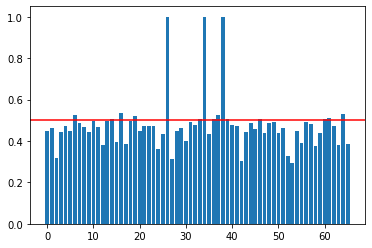

In [92]:
# Negative
print("NEGATIVE")
percentage = n_negative_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_negative_engagements/n_engagements, color="red")
plt.show()

LIKE


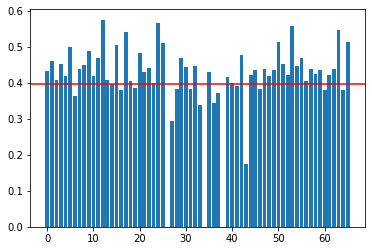

In [93]:
# Like
print("LIKE")
percentage = n_like_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_like_engagements/n_engagements, color="red")
plt.show()

RETWEET


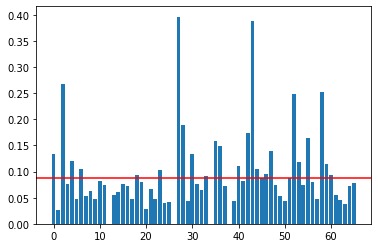

In [94]:
# Retweet
print("RETWEET")
percentage = n_retweet_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_retweet_engagements/n_engagements, color="red")
plt.show()

REPLY


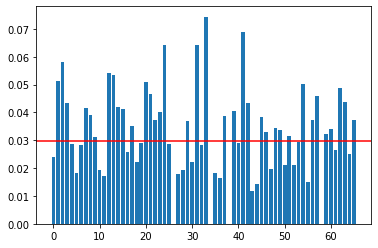

In [95]:
# Reply
print("REPLY")
percentage = n_reply_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_reply_engagements/n_engagements, color="red")
plt.show()

COMMENT


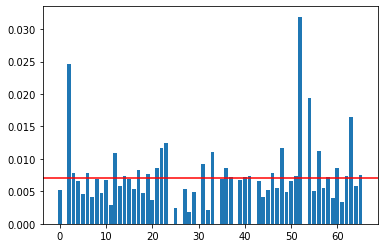

In [96]:
# Comment
print("COMMENT")
percentage = n_comment_engagements_arr / n_engagements_arr
plt.bar(language_types, percentage)
plt.axhline(n_comment_engagements/n_engagements, color="red")
plt.show()